In [4]:
import pandas as pd
import numpy as np

import seaborn as sns

import re

from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import gensim
from gensim import corpora, models, similarities
from gensim.models import CoherenceModel, HdpModel
from gensim.models.nmf import Nmf

from collections import OrderedDict

In [5]:
data_file = "./dreaddit/dreaddit-train-allTexts.csv"
train_df = pd.read_csv(data_file)
train_df.head()
print(train_df.shape)

(2838, 3)


## EDA

In [6]:
# How many human annotated topics are in the data?
stress_topics = list(set(train_df['subreddit'].tolist()))
print("Number of stress topics in the data: {}".format(len(stress_topics)))

Number of stress topics in the data: 10


In [7]:
# the shape of the data: how many tweets are in the data set?
print("Shape of the data: {}".format(train_df.shape))

Shape of the data: (2838, 3)


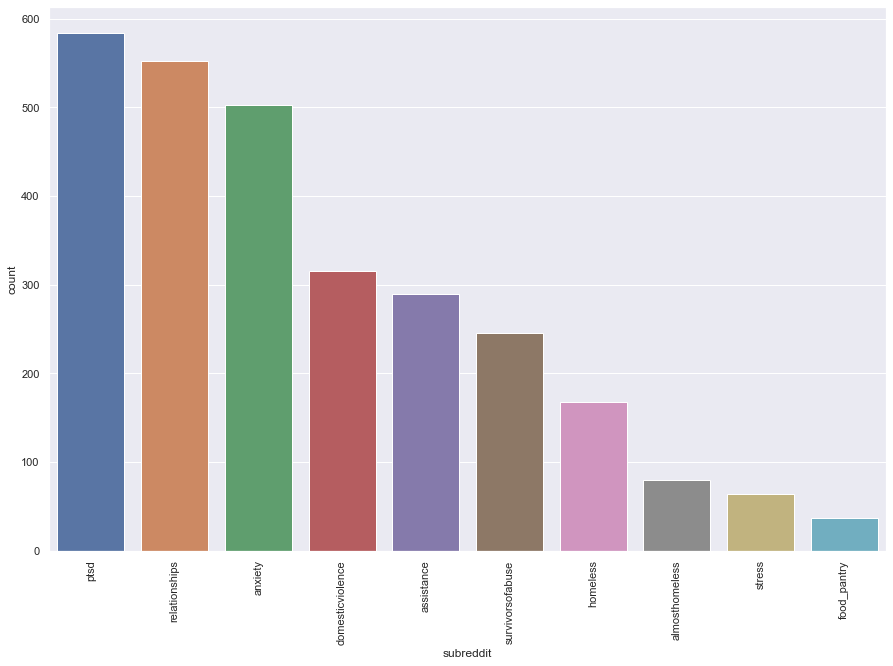

In [8]:
# the distributions of stress topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='subreddit', data=train_df, order = train_df['subreddit'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

Because some subreddits are more or less popular, the amount of data in each domain varies. We include ten total subreddits from five domains in our dataset. 

In [9]:
def getDomainsfromTopics(topic):
    if topic in ['domesticviolence', 'survivorsofabuse']:
        return 'abuse'
    elif topic in ['anxiety', 'stress']:
        return 'anxiety'
    elif topic in ['almosthomeless', 'assistance', 'food_pantry', 'homeless']:
        return 'financial'
    elif topic == 'ptsd':
        return 'PTSD'
    elif topic == 'relationships':
        return 'social'

train_df['domains'] = train_df.apply(lambda x: getDomainsfromTopics(x.subreddit), axis=1)
train_df.head()

,subreddit,text,sentiment,domains
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse


In [10]:
# How many stress domains are in the data now?
stress_domains = list(set(train_df['domains'].tolist()))
print("Number of stress domains in the data: {}".format(len(stress_domains)))

Number of stress domains in the data: 5


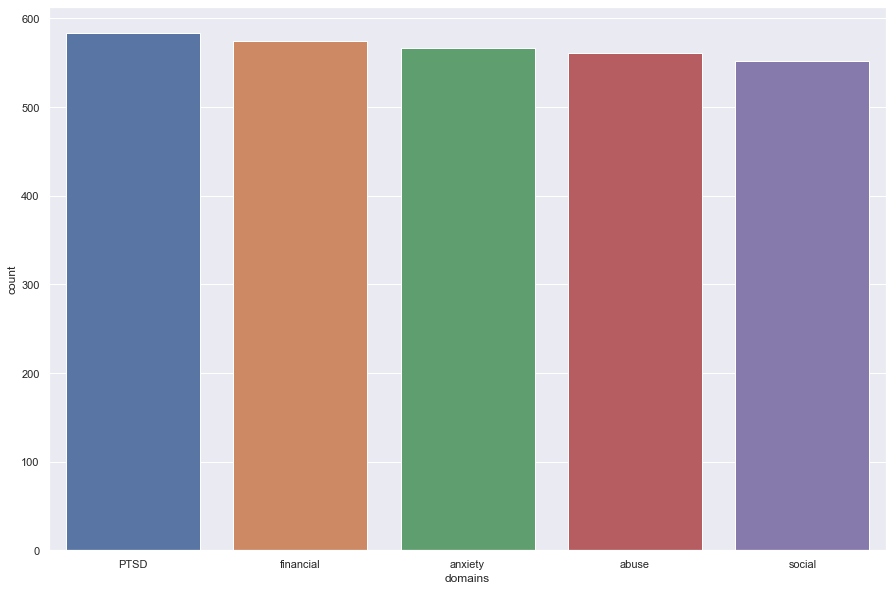

In [11]:
# the distributions of stress domains in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_domain = sns.countplot(x='domains', data=train_df, order = train_df['domains'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [12]:
def getSentiLabelFromScores(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
train_df['senti_label'] = train_df.apply(lambda x: getSentiLabelFromScores(x.sentiment), axis=1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


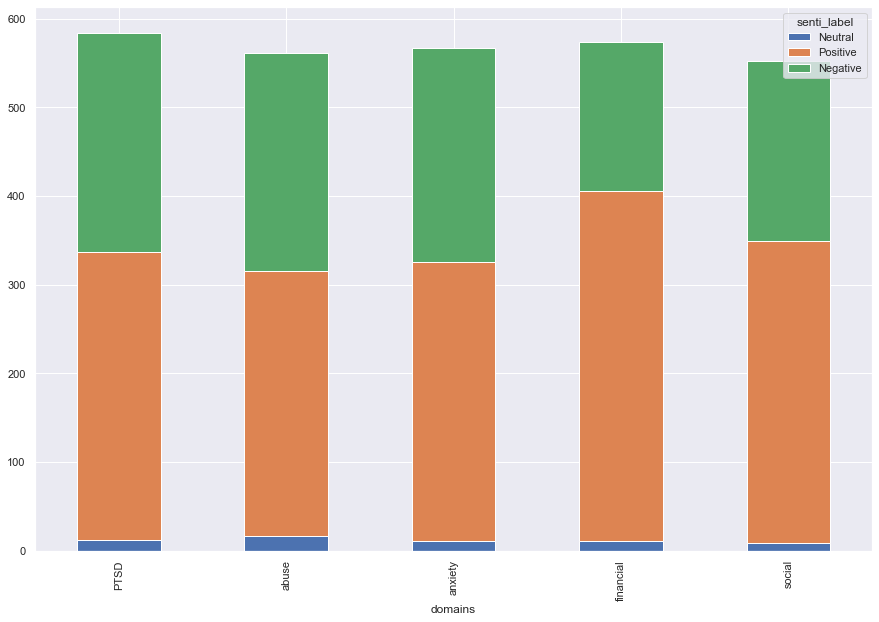

In [13]:
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

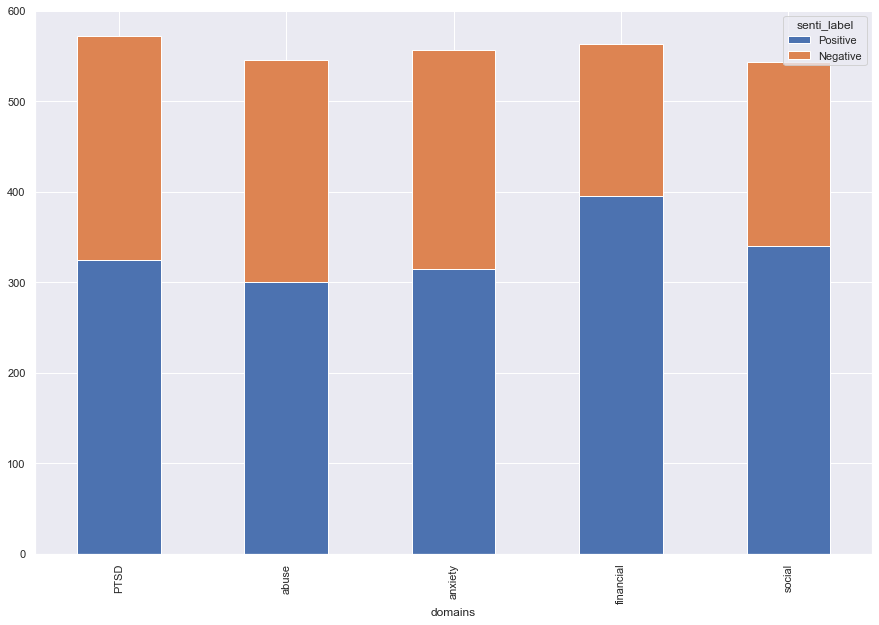

In [14]:
# drop Neutral rows since there are too few records
train_df = train_df.loc[train_df.senti_label != 'Neutral']
# Take a look at the distributions of human annotated/tagged sentiment by topic via a barplot
senti_labels = list(set(train_df['senti_label'].tolist()))
df_sentiment = train_df.groupby(['domains', 'senti_label'])['domains'].count().unstack('senti_label')
domains_mixture = df_sentiment[senti_labels].plot(kind='bar', stacked=True, legend = True)

In [15]:
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"He said he had not felt that way before, sugge...",-0.002742,PTSD,Negative
1,assistance,"Hey there r/assistance, Not sure if this is th...",0.292857,financial,Positive
2,ptsd,My mom then hit me with the newspaper and it s...,0.011894,PTSD,Positive
3,relationships,"until i met my new boyfriend, he is amazing, h...",0.141671,social,Positive
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,-0.204167,abuse,Negative


## Model

In [16]:
# Prepare the corpus for analysis
def preprocess_text(text, stem=False):
    """Preprocess one sentence: tokenizes, lowercases, applies the Porter stemmer,
     removes punctuation tokens and stopwords.
     Returns a list of strings."""
    toks = word_tokenize(text)
    # clean
    stops = stopwords.words('english')
    selfdefined_stops = ["n't", "the", "it", "get", "got", "gets", 
                         "my", "also", "one", "could", "would", "can", 
                         "as", "said", "go", "goes", "going", "went", 
                         "also", "is", "since", "these", "so", "really", 
                         "much", "what", "the", "still", "every", "any", 
                         "it", "make", "but" , "my", "like", "know", 
                         "something", "even", "tell", "told", "things", 
                         "feel", "want", "think", "take", "back", "never", 
                         "first", "last", "ca", "us", "thing", "always", 
                         "made", "else", "dont", "im", "find", "though", 
                         "let", "way", "come", "ever", "lot", "good", "bad", 
                         "maybe", "two", "little", "start", "try", "apparently", 
                         "joe", "seem", "give", "please", "next", "able", "put", 
                         "although", "etc", "long", "url", "say", "see", "sometimes",
                         "around", "another", "bit", "x200b", "edit", "ask"]
    stopwords_list = stops + selfdefined_stops
    # stem
    if stem:
        stemmer = PorterStemmer()
        toks = [stemmer.stem(tok) for tok in toks]
    toks = [manual_stem(tok) for tok in toks]
    # remove punctuation
    toks_nopunc = [tok.lower() for tok in toks if tok not in string.punctuation]
    # remove stopwords
    toks_nostop = [tok for tok in toks_nopunc if tok not in stopwords_list]
    toks_tidy = [tok for tok in toks_nostop if re.match(r'[a-zA-Z]+', tok) and len(tok) >= 3]
    return toks_tidy

In [17]:
def manual_stem(tok):
    if tok in ['trying', 'tried', 'tries']:
        return 'try'
    if tok in ['getting', 'got', 'gets']:
        return 'get'
    if tok in ['made', 'making', 'makes']:
        return 'make'
    if tok in ['took', 'taking', 'takes']:
        return 'take'
    if tok in ['wanted', 'wants']:
        return 'want'
    if tok in ['goes', 'went', 'going']:
        return 'go'
    if tok in ['told', 'telling', 'tells']:
        return 'tell'
    if tok in ['feeling', 'felt', 'feels', 'feelings']:
        return 'feel'
    if tok in ['found', 'finds']:
        return 'find'
    if tok in ['asked', 'asks', 'asking']:
        return 'ask'
    if tok in ['seems', 'seemed']:
        return 'seem'
    if tok in ['working', 'worked', 'works']:
        return 'work'
    if tok in ['starting', 'started', 'starts']:
        return 'start'
    if tok in ['coming', 'came', 'comes']:
        return 'come'
    if tok in ['best', 'well']:
        return 'good'
    if tok in ['called', 'calls']:
        return 'call'
    if tok in ['thinking', 'thought', 'thinks']:
        return 'think'
    if tok in ['trying', 'tried', 'tries']:
        return 'try'
    if tok == 'years':
        return 'year'
    if tok == 'months':
        return 'month'
    if tok == 'days':
        return 'day'
    if tok == 'friends':
        return 'friend'
    if tok == 'thanks':
        return 'thank'
    if tok == 'jobs':
        return 'job'
    else:
        return tok

In [18]:
train_df['text'] = train_df.apply(lambda x: preprocess_text(x.text), axis = 1)
train_df.head()

,subreddit,text,sentiment,domains,senti_label
0,ptsd,"[suggeted, rest, trigger, ahead, youi, hypocon...",-0.002742,PTSD,Negative
1,assistance,"[hey, r/assistance, sure, right, place, post, ...",0.292857,financial,Positive
2,ptsd,"[mom, hit, newspaper, shocked, knows, play, hi...",0.011894,PTSD,Positive
3,relationships,"[met, new, boyfriend, amazing, kind, sweet, st...",0.141671,social,Positive
4,survivorsofabuse,"[october, domestic, violence, awareness, month...",-0.204167,abuse,Negative


In [19]:
# wordcloud
# Import the wordcloud library
from wordcloud import WordCloud

In [31]:
long_string = ''
string_list = train_df['text'].apply(lambda x: ' '.join([w for w in x]))
long_string = long_string.join([line for line in string_list])
long_string

"suggeted rest trigger ahead youi hypocondriac decide look doom hopes sucked rabbit hole ludicrous conspiracy stupid psychic test new age b.s. laugh road ended reading sense doom indicative various health ailments prone top doom gloom worried heart happen physical hourshey r/assistance sure right place post currently student intern sandia national labs work survey help improve marketing outreach efforts many schools recruit country looking current undergrad/grad stem students stem student stem students greatly appreciate help pass along short survey thank everyone helps survey entered drawing chance win three amazon gcsmom hit newspaper shocked knows play hitting smacking striking hitting violence sort person send vibe universe yesterday decided friend help friend move new place driving friend moving strikes shoulder address immediately time friend driving nearly collision car high marijuana friend moving backseat understand attention year olds peoples attention smacking guymet new boy

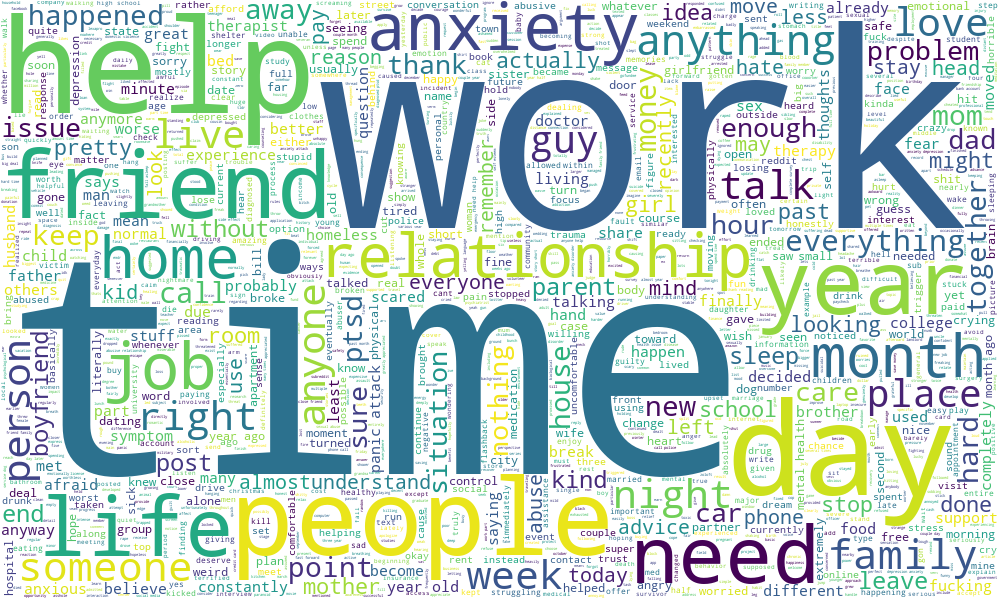

In [35]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", 
                      max_words=2000,
                      contour_color='steelblue', 
                      width=1000, height=600)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [16]:
texts = train_df['text']
dictionary = corpora.Dictionary(texts)
print(dictionary.token2id)

{'age': 0, 'ahead': 1, 'ailments': 2, 'b.s.': 3, 'conspiracy': 4, 'decide': 5, 'doom': 6, 'ended': 7, 'gloom': 8, 'happen': 9, 'health': 10, 'heart': 11, 'hole': 12, 'hopes': 13, 'hours': 14, 'hypocondriac': 15, 'indicative': 16, 'laugh': 17, 'look': 18, 'ludicrous': 19, 'new': 20, 'physical': 21, 'prone': 22, 'psychic': 23, 'rabbit': 24, 'reading': 25, 'rest': 26, 'road': 27, 'sense': 28, 'stupid': 29, 'sucked': 30, 'suggeted': 31, 'test': 32, 'top': 33, 'trigger': 34, 'various': 35, 'worried': 36, 'youi': 37, 'along': 38, 'amazon': 39, 'appreciate': 40, 'chance': 41, 'country': 42, 'current': 43, 'currently': 44, 'drawing': 45, 'efforts': 46, 'entered': 47, 'everyone': 48, 'gcs': 49, 'greatly': 50, 'help': 51, 'helps': 52, 'hey': 53, 'improve': 54, 'intern': 55, 'labs': 56, 'looking': 57, 'many': 58, 'marketing': 59, 'national': 60, 'outreach': 61, 'pass': 62, 'place': 63, 'post': 64, 'r/assistance': 65, 'recruit': 66, 'right': 67, 'sandia': 68, 'schools': 69, 'short': 70, 'stem': 71

In [17]:
# A major question in using LDA for topic modeling is what is is the proper set of
# hyperparmeters to generate the optimal set of topics for the coprus of documents
# under examination. Gensim includes methods for computing the Perplexity and Topic 
# Coherence of a corpus. One appraoch is to sample an LDA model for a range of 
# for perplexity and topic coherence and select the appropriate number of topics
# from a point of minimum perplexity and maximium topic coherence.

corpus = [dictionary.doc2bow(text) for text in texts]

# However, recent studies have shown that predictive likelihood (or equivalently, perplexity) and human judgment are often not correlated, 
# and even sometimes slightly anti-correlated.
# So only using coherence score to evaluate models in our project
# perplexity_lda = []
coherence_lda = []
topic_count_lda = []

for num_topics in range(2, 16, 1):
    
    print("Computing the lda model using {} topics".format(num_topics))
    
    topic_lda = models.LdaModel(corpus,
                                id2word = dictionary,
                                num_topics = num_topics,
                                iterations = 1000,
                                alpha = 'auto')
    corpus_lda = topic_lda[corpus] # Use the bow corpus
    
    topic_count_lda.append(num_topics)
    
#     # a measure of how good the model is. the lower, the better.
#     perplexity_lda.append(topic_lda.log_perplexity(corpus))

    # Compute Coherence Score
    cm = CoherenceModel(model=topic_lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    coherence_lda.append(cm.get_coherence())

Computing the lda model using 2 topics
Computing the lda model using 3 topics
Computing the lda model using 4 topics
Computing the lda model using 5 topics
Computing the lda model using 6 topics
Computing the lda model using 7 topics
Computing the lda model using 8 topics
Computing the lda model using 9 topics
Computing the lda model using 10 topics
Computing the lda model using 11 topics
Computing the lda model using 12 topics
Computing the lda model using 13 topics
Computing the lda model using 14 topics
Computing the lda model using 15 topics


In [18]:
# Pull the resulting data into a pandas dataframe
topics_lda = pd.DataFrame({'coherence': coherence_lda},
                         index = topic_count_lda)

topics_lda

,coherence
2,-2.779783
3,-2.768832
4,-2.667669
5,-2.833834
6,-3.086956
7,-2.884340
8,-2.992807
9,-2.945873
10,-3.155675
11,-3.082681


Text(0.5, 1.0, 'Coherence Scores of LDA Models')

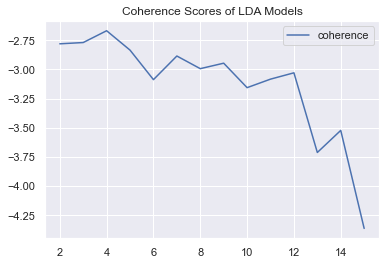

In [32]:
lines = topics_lda.plot.line()
lines.set_title("Coherence Scores of LDA Models")
# the higher the better

In [33]:
# Gensim LDA stores all the text for processing into a corpus object
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
# the higest coherence
total_topics = 4

# lda model
lda_model = models.LdaModel(corpus, id2word = dictionary, num_topics = total_topics, iterations = 1000, alpha='auto')
# Show first n=10 important words in the topics:
lda_model.show_topics(total_topics, 10)

[(0,
  '0.010*"time" + 0.010*"year" + 0.010*"help" + 0.009*"work" + 0.007*"day" + 0.007*"anxiety" + 0.006*"need" + 0.006*"life" + 0.006*"month" + 0.006*"people"'),
 (1,
  '0.008*"work" + 0.008*"friend" + 0.007*"time" + 0.007*"year" + 0.005*"job" + 0.004*"month" + 0.004*"life" + 0.004*"family" + 0.004*"anyone" + 0.003*"abuse"'),
 (2,
  '0.007*"time" + 0.005*"people" + 0.005*"day" + 0.004*"help" + 0.004*"work" + 0.004*"home" + 0.003*"anxiety" + 0.003*"need" + 0.003*"ptsd" + 0.003*"year"'),
 (3,
  '0.008*"friend" + 0.007*"time" + 0.007*"year" + 0.007*"day" + 0.006*"people" + 0.005*"life" + 0.005*"help" + 0.005*"right" + 0.005*"work" + 0.004*"love"')]

In [34]:
# Load the topic - term data into an python dictionary
data_lda_model = {i: OrderedDict(lda_model.show_topic(i,10)) for i in range(total_topics)}
data_lda_model

{0: OrderedDict([('time', 0.010272943),
              ('year', 0.010189586),
              ('help', 0.01018166),
              ('work', 0.008675577),
              ('day', 0.007080934),
              ('anxiety', 0.0068923407),
              ('need', 0.006121675),
              ('life', 0.0058403173),
              ('month', 0.005814651),
              ('people', 0.005643219)]),
 1: OrderedDict([('work', 0.008111379),
              ('friend', 0.0077032386),
              ('time', 0.007233899),
              ('year', 0.0068756426),
              ('job', 0.0048172576),
              ('month', 0.0040420736),
              ('life', 0.0036313112),
              ('family', 0.0036116126),
              ('anyone', 0.0035810922),
              ('abuse', 0.0033720739)]),
 2: OrderedDict([('time', 0.006869951),
              ('people', 0.0045368085),
              ('day', 0.0045150705),
              ('help', 0.0043391683),
              ('work', 0.003960679),
              ('home', 0.0036902474),

In [35]:
# infer the distribution of topics according to the lda model
topics = []
probs = []
max_to_show = 10

for k, i in enumerate(range(len(texts))):
    try:
        bow = dictionary.doc2bow(texts[i])
        doc_topics = lda_model.get_document_topics(bow, minimum_probability = 0.01)
        # topic with the highest probability
        topics_sorted = sorted(doc_topics, key = lambda x: x[0], reverse = True)
        topics.append(topics_sorted[0][0])
        probs.append("{}".format(topics_sorted[0][1]))

        # Dump out the topic and probability assignments for the first 20 texts
        if k < max_to_show:
            print("Text {}: {}".format(k, topics_sorted))
    except KeyError:
        pass

train_df['LDAtopic'] = pd.Series(topics)
train_df['LDAprob'] = pd.Series(probs)

Text 0: [(0, 0.99341255)]
Text 1: [(2, 0.8709727), (1, 0.12375417)]
Text 2: [(3, 0.9946382)]
Text 3: [(3, 0.99561477)]
Text 4: [(0, 0.99342823)]
Text 5: [(3, 0.9889599)]
Text 6: [(3, 0.9923914)]
Text 7: [(0, 0.991269)]
Text 8: [(2, 0.9892008)]
Text 9: [(3, 0.2119635), (0, 0.7829388)]


In [36]:
# Resort the dataframe according to the human annotated topic and lda topic
train_df.sort_values(['domains', 'LDAtopic'], ascending=[True, True], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
430,ptsd,"[unstable, telling, parents, option, easy, red...",0.191667,PTSD,Positive,0.0,0.9953765273094177
1072,ptsd,"[night, sweats, bed, stinks, wash, sheets, dai...",-0.528571,PTSD,Negative,0.0,0.9948394298553467
597,ptsd,"[veteran, participate, study, received, mariju...",0.150000,PTSD,Positive,0.0,0.9942783117294312
1171,ptsd,"[guys, ptsd, suicide, related, incident, ready...",-0.020833,PTSD,Negative,0.0,0.9935858845710754
0,ptsd,"[suggeted, rest, trigger, ahead, youi, hypocon...",-0.002742,PTSD,Negative,0.0,0.9934125542640686
917,ptsd,"[call, relive, trauma, talk, emotional, respon...",0.266667,PTSD,Positive,0.0,0.9930820465087891
621,ptsd,"[thank, reading, time, update, probably, add, ...",0.230000,PTSD,Positive,0.0,0.9927022457122803
589,ptsd,"[away, world, talk, uncomfortable, people, hat...",-0.650000,PTSD,Negative,0.0,0.9925000071525574
1195,ptsd,"[unnecessary, talk, happened, nightmares, away...",-0.233333,PTSD,Negative,0.0,0.9915217161178589
687,ptsd,"[different, occasions, people/objects, remind,...",0.100694,PTSD,Positive,0.0,0.991237998008728


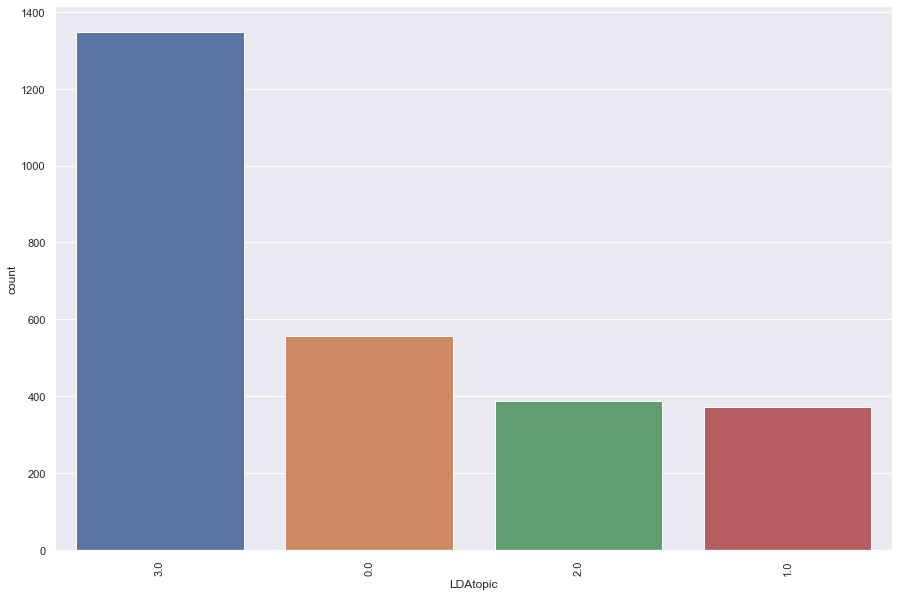

In [37]:
# the distributions of LDA assigned topics in the data via a barplot
sns.set(rc={'figure.figsize':(15,10)})
by_topic = sns.countplot(x='LDAtopic', data=train_df, order = train_df['LDAtopic'].value_counts().index)

for item in by_topic.get_xticklabels():
    item.set_rotation(90)

In [38]:
# Resort the dataframe according to the the lda assigned topic and the assocoiated probability
train_df.sort_values(['LDAtopic', 'LDAprob'], ascending=[True, False], inplace=True)
train_df.head(10)

,subreddit,text,sentiment,domains,senti_label,LDAtopic,LDAprob
292,domesticviolence,"[betrayed, system, fiance, blackout, drunk, ph...",-2.321429e-01,abuse,Negative,0.0,0.9973294138908386
930,ptsd,"[certainty, scared, fuck, work, better, show, ...",1.390000e-17,PTSD,Positive,0.0,0.9967718720436096
1468,ptsd,"[exhausted, continuing, work, god, tired, year...",3.333333e-02,PTSD,Positive,0.0,0.9964810013771057
1540,relationships,"[friend, struggling, alcoholism, bulimia, town...",1.000000e-01,social,Positive,0.0,0.9964273571968079
1121,assistance,"[surprise, friend, kindness, strangers, crowd,...",-3.333333e-02,financial,Negative,0.0,0.9959951043128967
1085,relationships,"[work, sister, sister, great, job, firm, intro...",4.028571e-01,social,Positive,0.0,0.9959354996681213
511,ptsd,"[used, sleeping, pills, anti, anxiety, medicin...",5.590909e-01,PTSD,Positive,0.0,0.9957489967346191
1862,relationships,"[girlfriend, real, problems, past, month, enjo...",1.813492e-01,social,Positive,0.0,0.9957489967346191
760,assistance,"[arguments, reasoning, behind, male, cancer, t...",6.944444e-02,financial,Positive,0.0,0.9956030249595642
1871,almosthomeless,"[car, job, job, baby, born, better, leeching, ...",1.666667e-01,financial,Positive,0.0,0.9956004023551941


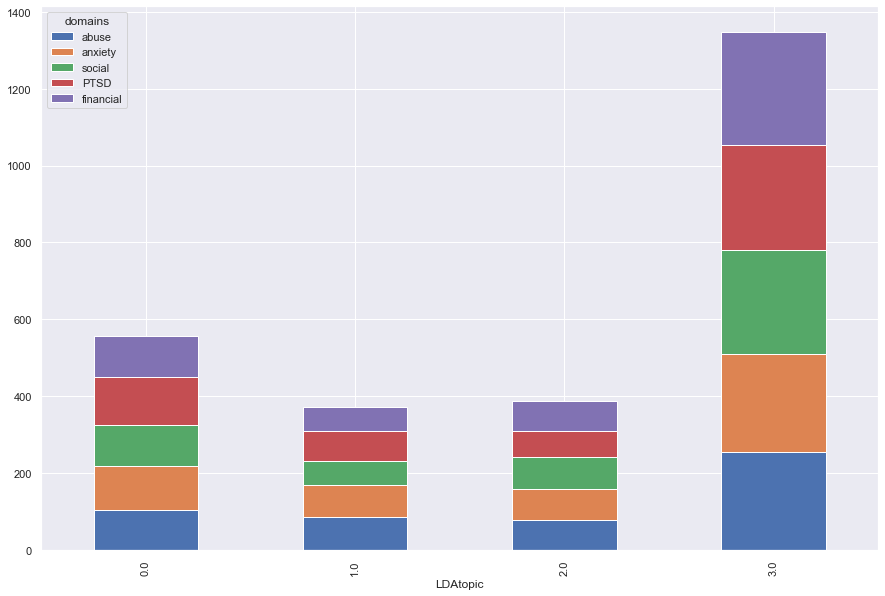

In [39]:
# the topic distrubtions related to the original human annotated/tagged topics
df = train_df.groupby(['LDAtopic', 'domains'])['LDAtopic'].count().unstack('domains')
topic_mixture = df[stress_domains].plot(kind='bar', stacked=True, legend = True)

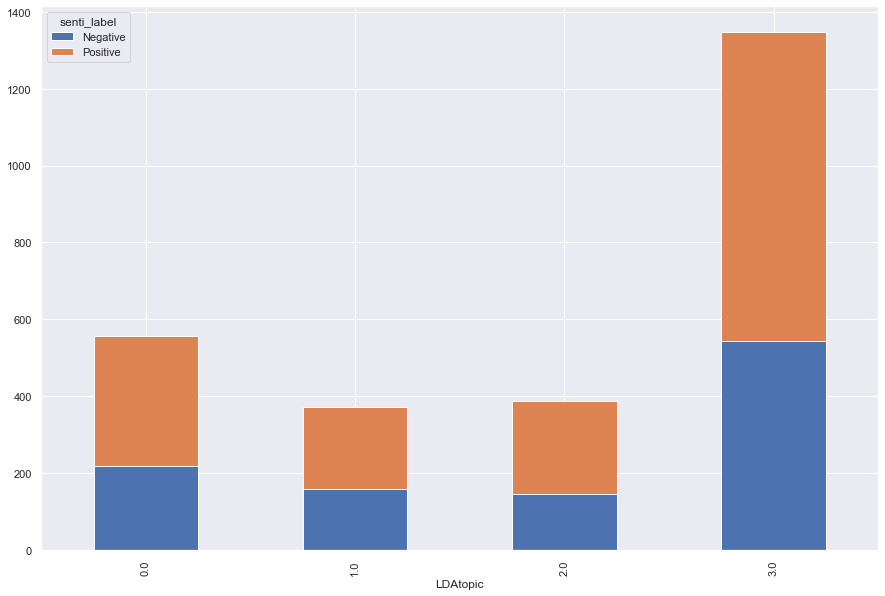

In [40]:
#  the topic distrubtions related to the original human annotated/tagged sentiment
human_sentiment = list(set(train_df['senti_label'].tolist()))
df2 = train_df.groupby(['LDAtopic', 'senti_label'])['LDAtopic'].count().unstack('senti_label')
topic_mixture = df2[human_sentiment].plot(kind='bar', stacked=True, legend = True)

In [28]:
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

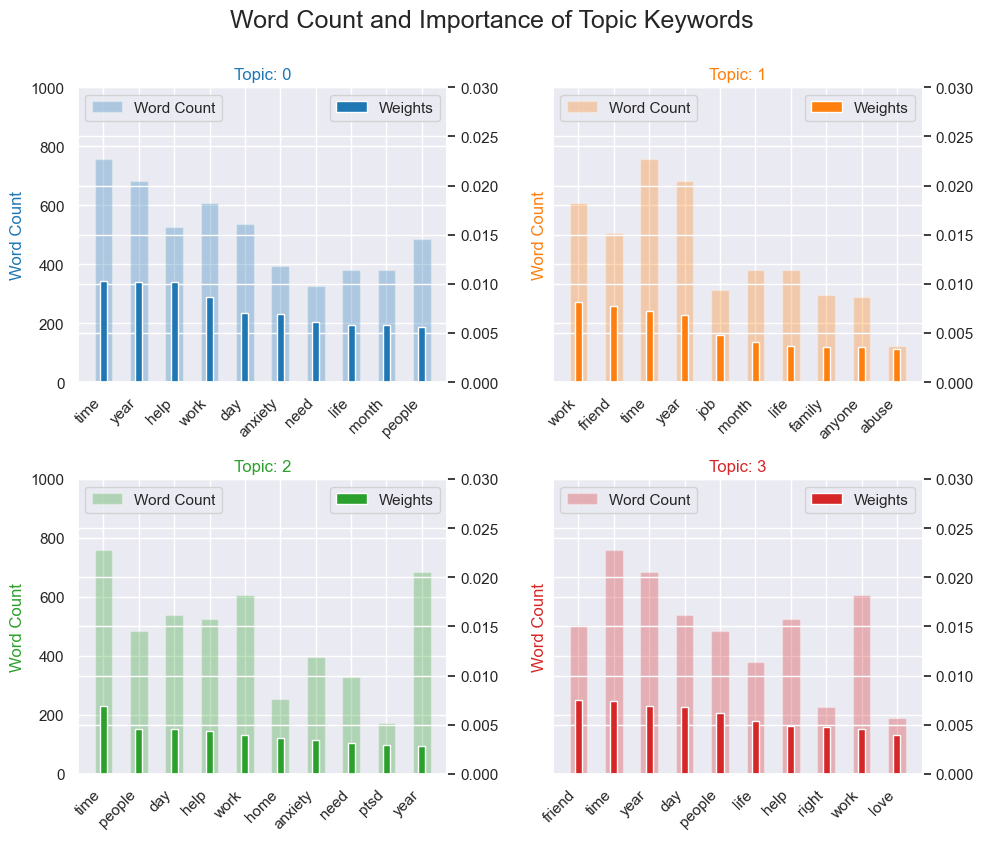

In [41]:
# word count importance of topic keywords
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(10,8), sharey=True, dpi=100)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=45, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=18, y=1.05)    
plt.show()

In [30]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [42]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.028580 -0.044268       1        1  34.579067
3     -0.018209 -0.037306       2        1  34.181293
1     -0.040842  0.070777       3        1  17.086174
2      0.087631  0.010797       4        1  14.153461, topic_info=          Term        Freq       Total Category  logprob  loglift
88      friend  451.000000  451.000000  Default  30.0000  30.0000
80        work  526.000000  526.000000  Default  29.0000  29.0000
896  treatment  101.000000  101.000000  Default  28.0000  28.0000
556      abuse  111.000000  111.000000  Default  27.0000  27.0000
579     sexual   47.000000   47.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
304     anyone   29.301548  263.431824   Topic4  -5.9676  -0.2409
103     person   26.018774  195.070724   Topic4  -6.0864  -0.0593
88      friend   32.387806  451.126648   Topic4  -5.8675  -0.6788
461   anything   26.516539  212.422729   Topic4  -6.0675  -0.1256
117       year   32.850891  603.411194   Topic4  -5.8533  -0.9554

[344 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
556       1  0.178739   abuse
556       2  0.294920   abuse
556       3  0.420037   abuse
556       4  0.107244   abuse
3943      4  0.914010  abuses
...     ...       ...     ...
597       4  0.108566   wrong
117       1  0.472315    year
117       2  0.316534    year
117       3  0.157438    year
117       4  0.054689    year

[620 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

When there are 3 topics in this corpus, these topic clusters achieve the furthest distances, 
indicating the distinguishing differences between these topics.

According to LIWC Dictionary:
